# Terrain Classification
### Created by Keenan McConkey 2019.5.17

In [1]:
# Imports

from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras
import pandas as pd

import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy import signal
from scipy import stats

## Part 1 - Importing Datasets

In [2]:
# Prepare for import

datasets = []
raw_datasets = []
datasets_np = []
raw_datasets_np = []

dataset_paths = glob.glob('imu_data/Sensor_*')
N_DATASETS = len(dataset_paths)
print('Num Datasets: {}'.format(N_DATASETS))

dataset_paths

Num Datasets: 5


['imu_data/Sensor_record_20190429_173940_grass.csv',
 'imu_data/Sensor_record_20190429_173526_sidewalk.csv',
 'imu_data/Sensor_record_20190429_173109_gravel.csv',
 'imu_data/Sensor_record_20190429_172255_concrete.csv',
 'imu_data/Sensor_record_20190429_172846_asphalt.csv']

In [3]:
# Import datasets as an array of Pandas DataFrames

TRIM_LEN = 2000 # Number of data points to trim from each side
N_DATA_COL = 6

dataset_columns = ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro', 'Time']
dataset_labels = ['Grass', 'Sidewalk', 'Gravel', 'Asphalt', 'Concrete']

for dataset_path in dataset_paths:
    dataset = pd.read_csv(dataset_path)
    
    # Drop unused paramaters
    dataset = dataset.drop(['YYYY-MO-DD HH-MI-SS_SSS', 'ACCELEROMETER X (m/s²)',
                            'ACCELEROMETER Y (m/s²)', 'ACCELEROMETER Z (m/s²)'], axis=1)
    dataset.columns = dataset_columns
    
    # Trim edges to account for startup time
    dataset = dataset[TRIM_LEN:-TRIM_LEN]
   
    raw_datasets.append(dataset)

raw_datasets[0].head(n=20)

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Time
2000,0.69,1.78,0.57,0.27,0.00,0.17,10005
2001,0.69,1.78,0.57,0.27,0.00,0.17,10011
2002,-0.94,1.51,0.11,0.38,0.02,0.16,10016
2003,-0.94,1.51,0.11,0.38,0.02,0.16,10020
2004,-0.94,1.51,0.11,0.38,0.02,0.16,10025
2005,-0.94,1.51,0.11,0.38,0.02,0.16,10032
2006,-0.94,1.51,0.11,0.38,0.02,0.16,10035
2007,-0.94,1.51,0.11,0.38,0.02,0.16,10040
2008,-0.94,1.51,0.11,0.38,0.02,0.16,10045
2009,-0.94,1.51,0.11,0.38,0.02,0.16,10050


It looks like the update rate of the IMU is non deterministic and lower than the rate the phone samples it at, i.e. the phone receives a non-deterministic number of sequential identical measurements from the IMU when polling at approx 200 Hz.

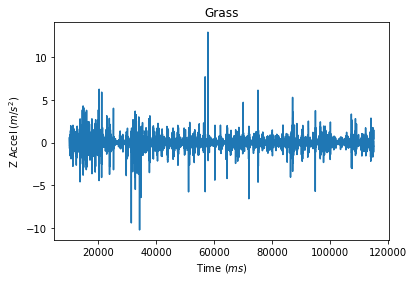

In [4]:
# Plot an example dataset

plt.plot(raw_datasets[0]['Time'], raw_datasets[0]['Z Accel'])
plt.xlabel('Time ($ms$)')
plt.ylabel('Z Accel ($m/s^2$)')
plt.title('Grass')
plt.show()

In [5]:
'''Plot given x annd y axes for every dataset in given array of datasets'''
def plot_all(n_datasets, labels, x_axis, y_axis, x_unit='($ms$)', y_unit='($m/s^2$)'):
    fig = plt.figure(figsize=(25, 15))
    fig.clear()
    
    n_axes = len(n_datasets)
    rows = int((n_axes + 1) / 2)
    
    # Grid of subplots
    gs = gridspec.GridSpec(rows, 2)
        
    axes = []
    row, col = 0, 0
    
    for i in range(n_axes):
        # Take a whole row (odd num labels only)
        if (i == n_axes-1 and n_axes % 2 == 1): 
            axes.append(fig.add_subplot(gs[row, :]))
        else:
            axes.append(fig.add_subplot(gs[row, col]))
        
        # Plot on new subplot
        axes[i].plot(n_datasets[i][x_axis], n_datasets[i][y_axis])
        axes[i].set_title(labels[i])
        axes[i].set_xlabel(x_axis + ' ' + x_unit)
        axes[i].set_ylabel(y_axis + ' ' + y_unit)
        
        # Only go two columns wide
        col += 1
        if (col == 2):
            row += 1
            col = 0
        
    plt.subplots_adjust(hspace=0.35, wspace=0.15)
    plt.show()

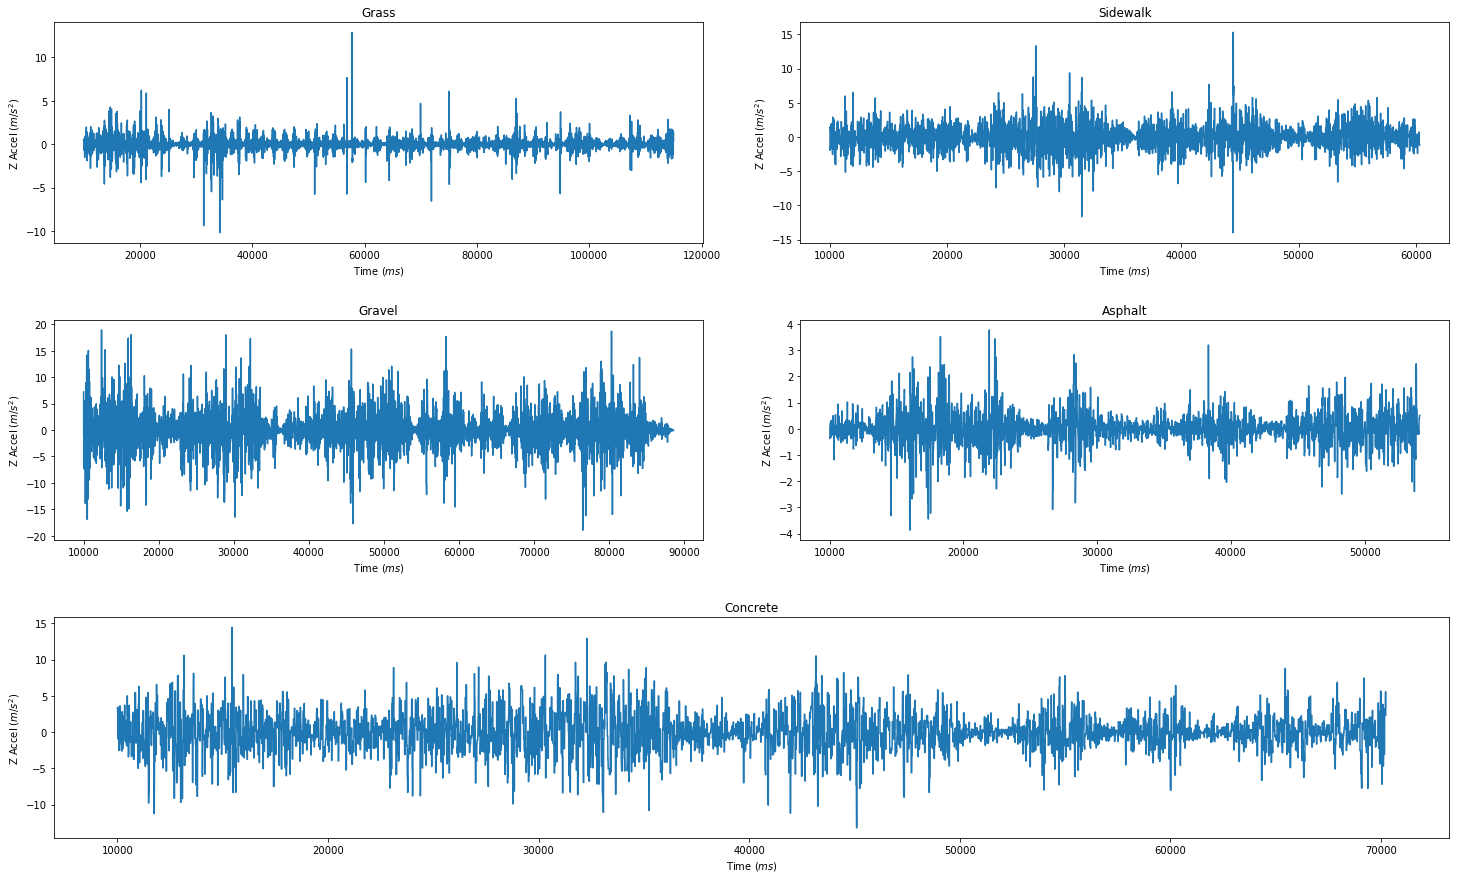

In [6]:
# Plot some examples
plot_all(raw_datasets, dataset_labels, x_axis='Time', y_axis='Z Accel')

## Part 2 - Filtering

Datasheets of smartphone level IMUs suggest that IMU filters data before sending it to the phone, and that the cutoff frequency of this filtering is configurable and changes with update frequency.

Based on the IMU update rate of about 20 ms, this cutoff frequency is already close to 40 Hz, sol filtering is probably unnecessary. Its hard to be sure about actual values because this is configured by the phone manufacturer.

In [7]:
# Convert Pandas DataFrames to NumPy array

for dataset in raw_datasets:
    raw_datasets_np.append(dataset.as_matrix())

raw_datasets_np[0][:, 0] # Should look like grass z linear acceleration

array([ 0.69,  0.69, -0.94, ...,  0.46,  0.46,  0.46])

### Part (a) - Butterworth Filtering

Butterworth filters can be high-pass/low-pass/bandpass, and attempt to have maximally flat frequency response in bandpass.

Changing the *cutoff frequency* of the filter affects the smoothness of the graph and amount of ringing. 

Changing the *order* of the filter can have significant effects on smoothness depending on the cutoff frequency. 

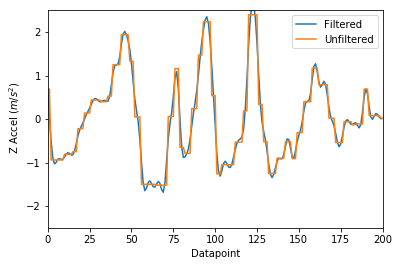

In [8]:
F_SAMP = 200 # Sampling frequency
F_CUT = 40 # Cutoff frequency

w = F_CUT / (F_SAMP / 2) # Normalize the frequency

# Get Butterworth filter parameters
b_butter, a_butter = signal.butter(N=6, Wn=w, btype='low')

# Filter each data column of every dataset
for dataset in raw_datasets_np: # Make a copy first
    datasets_np.append(np.copy(dataset))

for dataset in datasets_np:
    for i in range(N_DATA_COL):
        dataset[:, i] = signal.filtfilt(b_butter, a_butter, dataset[:,i])

# Compare filtered and unfiltered
plt.plot(datasets_np[0][:, 0], label='Filtered')
plt.plot(raw_datasets_np[0][:, 0], label='Unfiltered')
plt.xlim(0, 200)
plt.ylim(-2.5, 2.5)
plt.legend()
plt.xlabel('Datapoint')
plt.ylabel(' Z Accel ($m/s^2$)')
plt.show()

## Part 3 - Time Windows

### Part (a) - Finding an optimal time window

Strategy is to start with a large time window and work down. Plot variance of time window vs size and find a plateau.

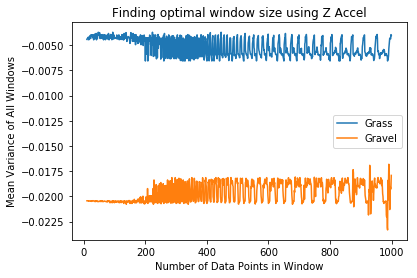

In [9]:
WINDOW_SIZE = np.arange(10, 1000, 1, dtype='int16')

# Work with filtered z acceleration, as an example
grass = np.transpose(datasets_np[0][:,2])
gravel = np.transpose(datasets_np[2][:,2])
grass_var = []
gravel_var = []

# Split windows and calculate the variance of each, then avg
for size in WINDOW_SIZE:
    n_grass_windows = int(len(grass) / size)
    n_gravel_windows = int(len(gravel) / size)
    
    # Take off remainder and split
    grass_trim = np.resize(grass, n_grass_windows * size)
    gravel_trim = np.resize(gravel, n_gravel_windows * size)
    
    grass_windows = np.split(grass_trim, n_grass_windows)
    gravel_windows = np.split(gravel_trim, n_gravel_windows)
    
    # Replace windows with their variances
    for window in grass_windows:
        window = np.mean(window)
    
    for window in gravel_windows:
        window = np.mean(window)
        
    grass_var.append(np.mean(grass_windows))
    gravel_var.append(np.mean(gravel_windows))
    
# Plot variance vs window size for both grass and gravel
plt.clf()
plt.plot(WINDOW_SIZE, grass_var, label='Grass')
plt.plot(WINDOW_SIZE, gravel_var, label='Gravel')
plt.title('Finding optimal window size using ' + dataset_columns[2])
plt.xlabel('Number of Data Points in Window')
plt.ylabel('Mean Variance of All Windows')
plt.legend()
plt.show()

Spikes seem to form as the number of windows decrease as the size of window the data can be split into also decreases. It looks like 200 data points should be fine for now.

Should look at classification accuracy and time later on.

### Part (b) - Creating Time Windowed Data

In [10]:
WINDOW_SIZE = 300
datasets_np_windowed = []

# Trim excess datapoints, then split into windows
for dataset in datasets_np:   
    n_windows = int(len(dataset) / WINDOW_SIZE)
    n_points = n_windows*WINDOW_SIZE
    
    dataset_windowed = np.resize(dataset, (n_points, N_DATA_COL + 1,))
    dataset_windowed = np.split(dataset_windowed, n_windows, axis=0)
    
    datasets_np_windowed.append(dataset_windowed)

In [11]:
# Check if its constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_np)))
print('Num windowed datasets: {}'.format(len(datasets_np_windowed)))
print('Shape of unwindowed data: {}'.format(datasets_np[0].shape))
print('Num of windows in first dataset: {}'.format(len(datasets_np_windowed[0])))
print('Shape of individual window: {}'.format(datasets_np_windowed[0][0].shape))

Num datasets: 5
Num windowed datasets: 5
Shape of unwindowed data: (20998, 7)
Num of windows in first dataset: 69
Shape of individual window: (300, 7)


Structure of the data right now:

`1D Array containing each dataset -> 1D Array containg each window -> 2D NP Array of actual data for each sensor`

## Part 4 - FFT and PSD

### Part (a) - FFT
Its possible the FFT is not valid due to the non determinisitic update rate. Probably needs some interpolation.

In [12]:
datasets_np_fft = []

# Find the FFT of each column of each data window of each dataset
for dataset in datasets_np_windowed:
    dataset_fft = []
    
    for window in dataset:
        # Add a new column for freq
        window_fft = np.resize(window, (int(WINDOW_SIZE / 2), window.shape[1] + 1))
        
        for i in range(N_DATA_COL):
            # Normalized FFT trimmed to Nyquist freq
            window_fft[:, i] = np.resize(np.abs(np.fft.fft(window[:, i], axis=0)) / WINDOW_SIZE, int(WINDOW_SIZE / 2))
            
        # Append the freq column
        window_fft[:, N_DATA_COL + 1] = np.linspace(0.0, F_SAMP / 2, int(WINDOW_SIZE / 2))
        
        dataset_fft.append(window_fft)
        
    datasets_np_fft.append(dataset_fft)

In [13]:
# Check again if its constructed correctly

print('Num FFT\'d windowed datasets: {}'.format(len(datasets_np_fft)))
print('Num of FFT\'d windows in first dataset: {}'.format(len(datasets_np_fft[0])))
print('Shape of FFT\'d individual window: {}'.format(datasets_np_fft[0][0].shape))

Num FFT'd windowed datasets: 5
Num of FFT'd windows in first dataset: 69
Shape of FFT'd individual window: (150, 8)


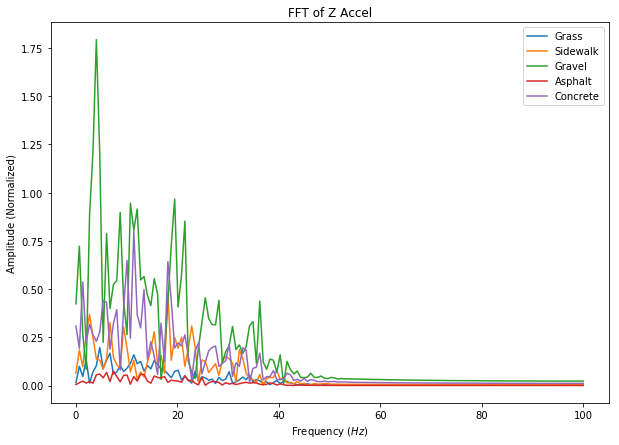

In [14]:
# Plot some Fourier transforms

plt.clf()
plt.figure(figsize=(10, 7))

for i in range(N_DATASETS):
    plt.plot(datasets_np_fft[i][0][:, N_DATA_COL+1], datasets_np_fft[i][0][:, 2], label=dataset_labels[i])

plt.xlabel('Frequency ($Hz$)')
plt.ylabel('Amplitude (Normalized)')
plt.title('FFT of ' + dataset_columns[2])
plt.legend()
plt.show()

The Butterworth cutoff frequency is pretty noticeable. Theres not an easily recognizable cutoff from the unfiltered data.

### Part (b) - PSD

In [15]:
datasets_np_psd = []

# Find the PSD of each column of each data window of each dataset
for dataset in datasets_np_windowed:
    dataset_psd = []
    
    for window in dataset:
        # Add a new column for freq
        window_psd = np.resize(window, (int(WINDOW_SIZE / 2), window.shape[1] + 1))
        
        for i in range(N_DATA_COL):
            # Normalized PSD - Returns frequencies and power density
            freq, Pxx = signal.periodogram(window[:, i], F_SAMP)
            window_psd[:, i] = np.resize(Pxx[1:], int(WINDOW_SIZE / 2))
            
        # Append freq column
        window_psd[:, N_DATA_COL + 1] = freq[:-1]
        
        dataset_psd.append(window_psd)
        
    datasets_np_psd.append(dataset_psd)

In [16]:
# Check again if its constructed correctly

print('Num PSD\'d windowed datasets: {}'.format(len(datasets_np_psd)))
print('Num of PSD\'d windows in first dataset: {}'.format(len(datasets_np_psd[0])))
print('Shape of PSD\'d individual window: {}'.format(datasets_np_psd[0][0].shape))

Num PSD'd windowed datasets: 5
Num of PSD'd windows in first dataset: 69
Shape of PSD'd individual window: (150, 8)


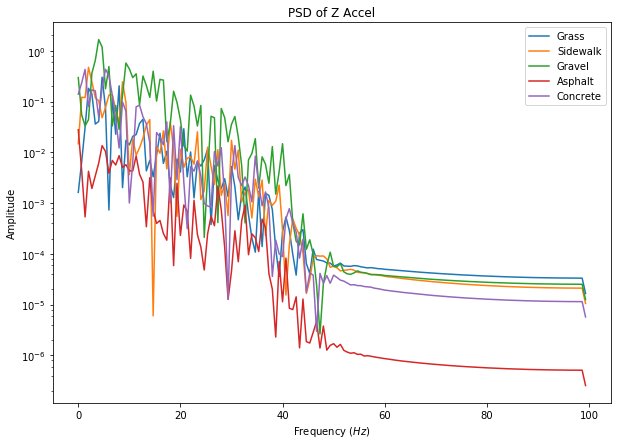

In [17]:
# Plot some PSDs

plt.clf()
plt.figure(figsize=(10, 7))

for i in range(N_DATASETS):
    plt.semilogy(datasets_np_psd[i][0][:, N_DATA_COL + 1], datasets_np_psd[i][0][:, 0], label=dataset_labels[i])

plt.legend()
plt.xlabel('Frequency ($Hz$)')
plt.ylabel('Amplitude')
plt.title('PSD of ' + dataset_columns[2])
plt.show()

Note that at this point, data is stored like:

`Labelled Terrain Dataset -> Time Window -> 2D NumPy Array (6 cols FFT/PSD in one direction, col 7 is time, col 8 is freq)`

## Part 5 - Feature Extraction

Idea for data :

`Labelled Terrain Dataset -> Direction ->  'Array with elements extracted from each time window, row = window #, col = feature`

In [53]:
# Some feature extraction functions needed

'''L2 norm of an array'''
def l2norm(array):
    return np.linalg.norm(array, ord=2)

'''Correlation of an array with itself'''
def autocorr(array):
    return np.correlate(array, array)

'''Root mean squared of an array'''
def rms(array):
    return np.sqrt(np.mean(array ** 2))

'''Zero crossing rate of an array as a fraction of total size of array'''
def zcr(array):
    # Locations where array > 0, put -1 and 1 for rising/falling,
    #  divide by total datapoints
    return len(np.nonzero(np.diff(array > 0))[0]) / len(array)

'''Return the centre frequency of the range of frequencies in the array'''
def freq_cen(array):
    freq_min = 0
    freq_max = 0
    ERROR = 0.05
        
    # Check for frequencies with amplitude higher than some error amount
    for j in range(len(array)):
        if (array[j] > ERROR):
            freq_max = j
        else:
            break
    
    return (freq_max - freq_min) / 2

In [35]:
'''Plot a feature on all terrains for each time window'''
def plot_feature_all_sets(datasets_feat, feat_names, dirn=0, feat=0):
    plt.clf()
    plt.figure(figsize=(8,6))
    
    for i in range(N_DATASETS):
        plt.plot(datasets_feat[i][dirn][:, feat], label=dataset_labels[i])
        
    plt.ylabel(feat_names[feat])
    plt.xlabel('Window #')
    plt.title(dataset_columns[dirn])
    plt.legend()
    plt.show()

### Part (a) - Time Domain Features

In [39]:
# Create array of features of each window for each dataset and direction

datasets_feat_time = []

# Time domain feature function names and actual names
time_feat_funcs = [np.mean, np.std, l2norm, autocorr, np.amax, np.amin, rms, zcr, stats.skew, stats.kurtosis]
time_feat_names = ['Mean', 'Std Dev', 'L2 Norm', 'Autocorrelation', 'Max', 'Min', 'Root Mean Squared',
                      'Zero Crossing Rate', 'Skew', 'Excess Kurtosis']

# Calculate features for each window of each column of each dataset
for dataset in datasets_np_windowed:
    directions = []

    for i in range(N_DATA_COL):
        feats = []
        
        '''Execute a function over all windows'''
        def function_all_windows(function):
            feat_in_window = []
            for window in dataset:
                feat_in_window.append(function(window[:, i]))
            
            # Already append to features array
            feats.append(feat_in_window)
            
        # Execute every function over all windows    
        for func in time_feat_funcs:
            function_all_windows(func)
    
        directions.append(np.transpose(np.array(feats)))
    
    datasets_feat_time.append(directions)

In [40]:
# Check if its constructed correctly and print some info

print('Num datasets: {}'.format(len(datasets_feat_time)))
print('Num directions: {}'.format(len(datasets_feat_time[0])))
print('Shape of one direction: {}'.format(datasets_feat_time[0][0].shape))

Num datasets: 5
Num directions: 6
Shape of one direction: (69, 10)


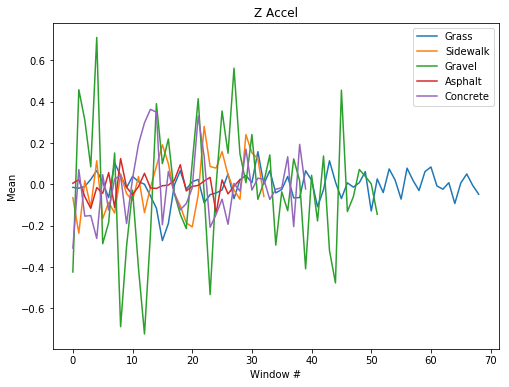

In [41]:
# Plot mean in z accel
plot_feature_all_sets(datasets_feat_time, time_feat_names, 2, 0)

### Part (b) - Frequency Domain Features

In [54]:
datasets_feat_freq = []

# Time domain feature function names and actual names
freq_feat_funcs = [np.mean, rms, freq_cen, np.std]
freq_feat_names = ['FFT Mean', 'FFT Root Mean Square', 'Frequency Center', 'FFT Standard Deviation']

# Calculate features for each window of each column of each dataset
for dataset in datasets_np_fft:
    directions = []

    for i in range(N_DATA_COL):
        feats = []
        
        '''Execute a function over all windows'''
        def function_all_windows(function):
            feat_in_window = []
            for window in dataset:
                feat_in_window.append(function(window[:, i]))
            
            # Already append to features array
            feats.append(feat_in_window)
            
        # Execute every function over all windows    
        for func in freq_feat_funcs:
            function_all_windows(func)
    
        directions.append(np.transpose(np.array(feats)))
    
    datasets_feat_freq.append(directions)

In [55]:
# Check if its constructed correctly and print some info

print('Num datasets: {}'.format(len(datasets_feat_freq)))
print('Num directions: {}'.format(len(datasets_feat_freq[0])))
print('Shape of one direction: {}'.format(datasets_feat_freq[0][0].shape))

Num datasets: 5
Num directions: 6
Shape of one direction: (69, 4)


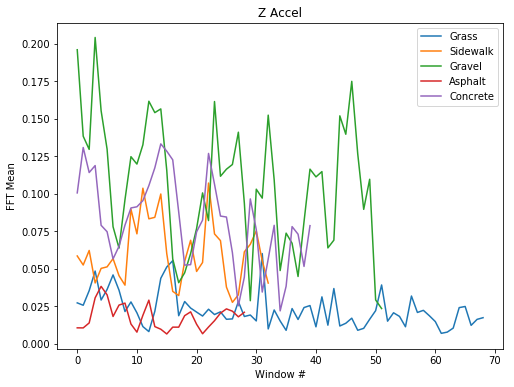

In [58]:
plot_feature_all_sets(datasets_feat_freq, freq_feat_names, 2, 0)

## PA

### Glossary

`Dataset` - Batch of data recorded on one terrain type

`Data Window` - Split up portion of a `Dataset`